## How to Perform Structural Preservation Analysis
C. Heiser, November 2019

In [1]:
from fcc_utils import * # contains code necessary for distance preservation analysis, including scanpy and related functions

In [2]:
# ignore numba warnings given by sc.pp.neighbors()
import numba; import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning); warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning); warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

---
### Preprocessing & Dimension Reduction with `scanpy`

`anndata` objects can be read straight from a file, or generated from an existing pandas dataframe or numpy array.  
These files can be comma- or tab-delimited, and compressed with `.zip` or `.gz`.  
Here, we will read in a file from [Macosko, _et al._ (2015)](https://www.ncbi.nlm.nih.gov/pubmed/26000488), which has cell and gene labels, and is in a cells-by-genes format.

In [3]:
retina = sc.read_text('inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz', delimiter='\t')

These objects have a bunch of useful attributes, and it's easy to calculate some QC metrics and preprocess the raw counts:

In [4]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
arcsinh(retina, layer='raw_counts', norm='l1', scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
retina.X = retina.layers['arcsinh_norm'].copy() # set normalized counts as .X slot in scanpy object

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 20478 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

We can use `sc.pp.highly_variable_genes` to filter our dataset for HVGs.  
Here, we will manually select genes by brute-force variance for simplicity:

In [5]:
retina.var['variance'] = retina.layers['raw_counts'].var(axis=0) # add gene variance as .var metadata
retina = retina[:,retina.var['variance'].nlargest(2000).index] # keep top 500 variable genes

In [6]:
retina.n_vars # should have 2000 genes now

2000

Now we can perform an initial dimension reduction with __principal component analysis__.

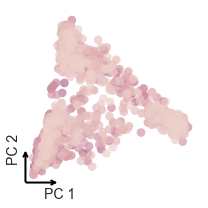

In [7]:
sc.tl.pca(retina, n_comps=100) # perform 100-component PCA on our feature-selected dataset
DR_plot(dim_name='PC', figsize=(3,3)).plot(retina.obsm['X_pca'], color=retina.obs['log1p_total_counts'])

Using the 100 principal components above, we can perform __Louvain__ clustering to determine subpopulations.

In [8]:
%%time
sc.pp.neighbors(retina, n_neighbors=30, n_pcs=100, random_state=18)
sc.tl.louvain(retina, key_added='louvain', random_state=18)

CPU times: user 2.81 s, sys: 111 ms, total: 2.92 s
Wall time: 2.46 s


Now we can perform our favorite low-dimensional embedding on the principal components of our dataset:

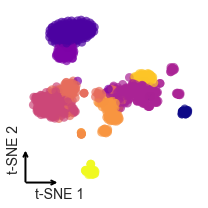

In [9]:
sc.tl.tsne(retina, use_rep='X_pca')
DR_plot(dim_name='t-SNE', figsize=(3,3)).plot_IDs(adata=retina, use_rep='X_tsne', obs_col='louvain')

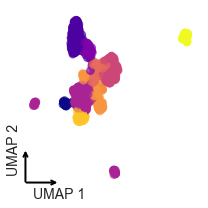

In [10]:
sc.tl.umap(retina)
DR_plot(dim_name='UMAP', figsize=(3,3)).plot_IDs(adata=retina, use_rep='X_umap', obs_col='louvain')

---
### Global Structure Preservation

We can easily apply the `scipy.spatial.distance.cdist()` function to different parts of our `AnnData` objects to get symmetric distance matrices between all cells in the dataset across multiple low-dimensional latent spaces.

In [11]:
%%time
# save distance matrix in AnnData object for easy access
retina.uns['X_pca_distances'] = cdist(retina.obsm['X_pca'], retina.obsm['X_pca'])
retina.uns['X_tsne_distances'] = cdist(retina.obsm['X_tsne'], retina.obsm['X_tsne'])

# calculate simple binary knn graph from the distance matrix above
knn_graph(retina.uns['X_pca_distances'], k=30, adata=retina, save_rep='pca_knn')
knn_graph(retina.uns['X_tsne_distances'], k=30, adata=retina, save_rep='tsne_knn')

CPU times: user 3.54 s, sys: 37.2 ms, total: 3.58 s
Wall time: 605 ms


Using our `distance_stats` function, we can calculate structural preservation metrics between latent t-SNE space and its corresponding native PCA space.  

In [12]:
%time pca_dist, tsne_dist, corr_stats, EMD = distance_stats(pre=retina.uns['X_pca_distances'], post=retina.uns['X_tsne_distances'])
knn = knn_preservation(pre=retina.uns['pca_knn']['graph'], post=retina.uns['tsne_knn']['graph'])
print('\nR: {}\nEMD: {}\nKnn Pres. (%): {}'.format(round(corr_stats[0],4), round(EMD,4), round(knn, 4)))

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
CPU times: user 685 ms, sys: 78.3 ms, total: 764 ms
Wall time: 342 ms

R: 0.7849
EMD: 0.2145
Knn Pres. (%): 97.0618


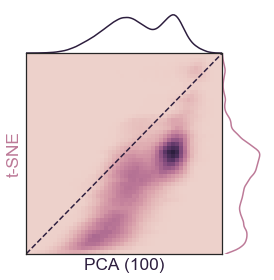

In [13]:
SP_plot(pre_norm=pca_dist, post_norm=tsne_dist, labels=['PCA (100)','t-SNE']).joint_plot_distance_correlation()

Looks like a pretty good correlation between t-SNE and PCA spaces (R > 0.7).  
You can also look at the normalized cumulative distance distributions in each projection and calculate the __Wasserstein metric__ or __Earth Mover's Distance__ between the two.

EMD: 0.2145


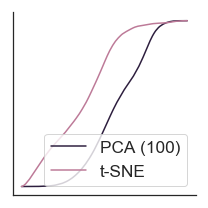

In [14]:
SP_plot(pre_norm=pca_dist, post_norm=tsne_dist, labels=['PCA (100)','t-SNE'], figsize=(3,3)).plot_cumulative_distributions()
print('EMD: {}'.format(round(EMD,4)))

__AND__ if we want to do this all very quickly, there's a wrapper function for `AnnData` objects so you don't have to manually calculate and save distance matrices as above.  
Let's do this for our UMAP calculations.

Calculating unique distances for latent space, X_umap
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for native space, X_pca
30-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation
Done!
CPU times: user 4.05 s, sys: 123 ms, total: 4.17 s
Wall time: 833 ms

R: 0.6146
EMD: 0.371
Knn Pres.: 96.9951


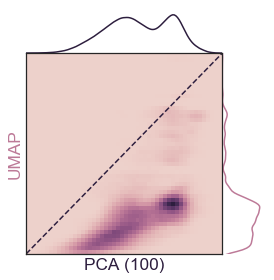

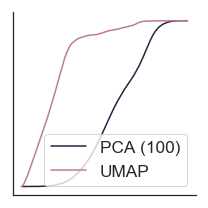

In [15]:
%time corr, EMD, knn = structure_preservation_sc(adata=retina, latent='X_umap', native='X_pca', k=30)
print('\nR: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0],4), round(EMD,4), round(knn, 4)))
SP_plot(pre_norm=retina.uns['X_pca_norm_distances'], post_norm=retina.uns['X_umap_norm_distances'], labels=['PCA (100)','UMAP']).joint_plot_distance_correlation()
SP_plot(pre_norm=retina.uns['X_pca_norm_distances'], post_norm=retina.uns['X_umap_norm_distances'], labels=['PCA (100)','UMAP'], figsize=(3,3)).plot_cumulative_distributions()

---
### Local Structure Preservation
We can extend this framework to defined substructures in our data.  
Here, let's look at cluster __"0"__ as output from the __Louvain__ algorithm above.  
First, plot this cluster in all three spaces (PCA, t-SNE, UMAP).

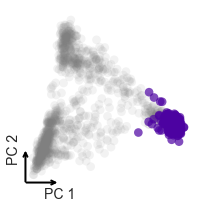

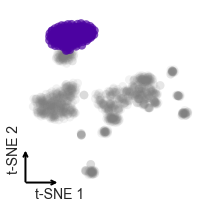

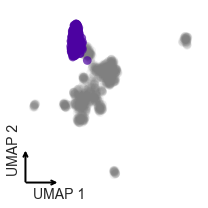

In [16]:
DR_plot(dim_name='PC', figsize=(3,3)).plot_IDs(adata=retina, use_rep='X_pca', obs_col='louvain', IDs=['0'])
DR_plot(dim_name='t-SNE', figsize=(3,3)).plot_IDs(adata=retina, use_rep='X_tsne', obs_col='louvain', IDs=['0'])
DR_plot(dim_name='UMAP', figsize=(3,3)).plot_IDs(adata=retina, use_rep='X_umap', obs_col='louvain', IDs=['0'])

We can subset our distance matrices by `adata.obs['louvain']` and calculate structural preservation metrics as before

In [17]:
subset_uns_by_ID(
    retina, 
    uns_keys=['X_pca_distances','X_tsne_distances','X_umap_distances'], 
    obs_col='louvain', 
    IDs=['0']
)

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions

R: 0.4832
EMD: 0.1482
CPU times: user 615 ms, sys: 84.8 ms, total: 700 ms
Wall time: 151 ms


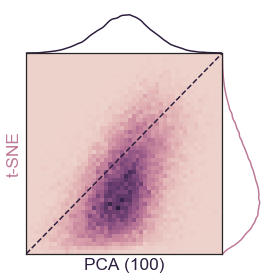

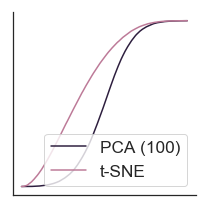

In [18]:
%%time
pca_dist_0, tsne_dist_0, corr_stats_0, EMD_0 = distance_stats(pre=retina.uns['X_pca_distances_0'], post=retina.uns['X_tsne_distances_0'])
print('\nR: {}\nEMD: {}'.format(round(corr_stats_0[0],4), round(EMD_0,4)))
SP_plot(pre_norm=pca_dist_0, post_norm=tsne_dist_0, labels=['PCA (100)','t-SNE'], figsize=(4,4)).joint_plot_distance_correlation()
SP_plot(pre_norm=pca_dist_0, post_norm=tsne_dist_0, labels=['PCA (100)','t-SNE'], figsize=(3,3)).plot_cumulative_distributions()

Let's do the same for __UMAP__ to compare to __t-SNE__.

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions

R: 0.3839
EMD: 0.205
CPU times: user 603 ms, sys: 93.6 ms, total: 697 ms
Wall time: 152 ms


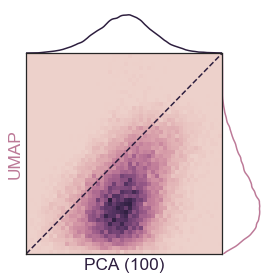

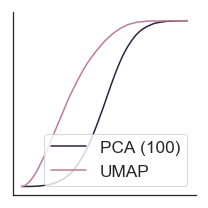

In [19]:
%%time
pca_dist_0, umap_dist_0, corr_stats_0, EMD_0 = distance_stats(pre=retina.uns['X_pca_distances_0'], post=retina.uns['X_umap_distances_0'])
print('\nR: {}\nEMD: {}'.format(round(corr_stats_0[0],4), round(EMD_0,4)))
SP_plot(pre_norm=pca_dist_0, post_norm=umap_dist_0, labels=['PCA (100)','UMAP'], figsize=(4,4)).joint_plot_distance_correlation()
SP_plot(pre_norm=pca_dist_0, post_norm=umap_dist_0, labels=['PCA (100)','UMAP'], figsize=(3,3)).plot_cumulative_distributions()

---
### Neighborhood Preservation

We also have a nice wrapper function to compare the _pairwise distance distributions_ between cells in three clusters.  
Let's pick a few cluster IDs and plot them in each latent space.

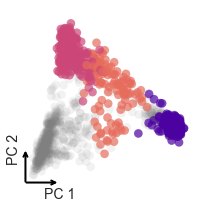

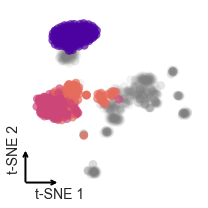

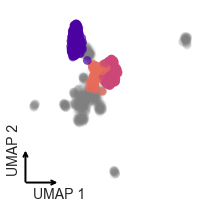

In [20]:
DR_plot(dim_name='PC', figsize=(3,3)).plot_IDs(adata=retina, use_rep='X_pca', obs_col='louvain', IDs=['0','4','2'])
DR_plot(dim_name='t-SNE', figsize=(3,3)).plot_IDs(adata=retina, use_rep='X_tsne', obs_col='louvain', IDs=['0','4','2'])
DR_plot(dim_name='UMAP', figsize=(3,3)).plot_IDs(adata=retina, use_rep='X_umap', obs_col='louvain', IDs=['0','4','2'])

Now run `cluster_arrangement_sc` to see how the local neighborhoods defined between substructures are altered in __t-SNE__ compared to __100-component PCA__.

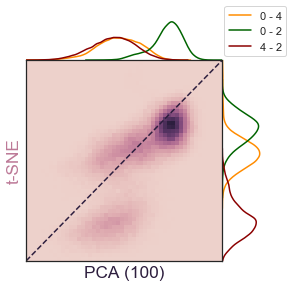

In [21]:
corr_tSNE, EMD_tSNE = cluster_arrangement_sc(
    adata=retina, 
    pre=retina.obsm['X_pca'], 
    post=retina.obsm['X_tsne'], 
    obs_col='louvain', IDs=['0','4','2'], 
    ax_labels=['PCA (100)','t-SNE'], 
    figsize=(4,4)
)

We can do the same thing for __UMAP__.

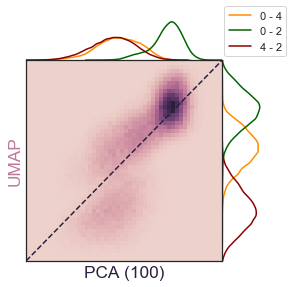

In [22]:
corr_UMAP, EMD_UMAP = cluster_arrangement_sc(
    adata=retina, 
    pre=retina.obsm['X_pca'], 
    post=retina.obsm['X_umap'], 
    obs_col='louvain', IDs=['0','4','2'], 
    ax_labels=['PCA (100)','UMAP'], 
    figsize=(4,4)
)

The correlation and EMD values _between_ each cluster are returned by the above function:

In [23]:
corr_tSNE

[0.3984684889092731, 0.37621949215015105, 0.4197486937204048]

In [24]:
corr_UMAP

[0.4858311108549366, 0.45230508997114094, 0.4296937677060048]

---
### Topological Cluster Preservation
Finally, to get an idea of the global arrangement of substructures relative to one another, we construct a minimum-spanning tree (MST) graph between cluster centroids in native and latent spaces.  
Permuted edges from one graph to another indicate rearrangement of cluster topology following dimension reduction.

In [25]:
find_centroids(retina, use_rep='X_pca', obs_col='louvain')
find_centroids(retina, use_rep='X_tsne', obs_col='louvain')
find_centroids(retina, use_rep='X_umap', obs_col='louvain')

The above function generates a `networkx` graph in `adata.uns['*_centroid_MST']`.  We can compare the `.edges` attribute of these graphs to determine which ones changed.  
Furthermore, we have a nice visualization function (`DR_plot().plot_centroids()`) to overlay the graph on our embeddings.

1 permuted edges from native space.


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


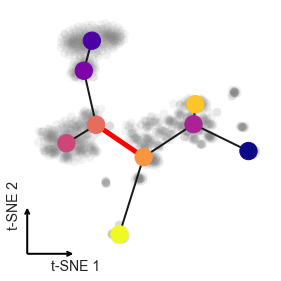

In [26]:
tsne_set = set(retina.uns['X_tsne_centroid_MST'].edges).difference(set(retina.uns['X_pca_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(tsne_set)))

DR_plot(dim_name='t-SNE', figsize=(4,4)).plot_centroids(adata=retina, obs_col='louvain', use_rep='X_tsne', highlight_edges=tsne_set)

2 permuted edges from native space.


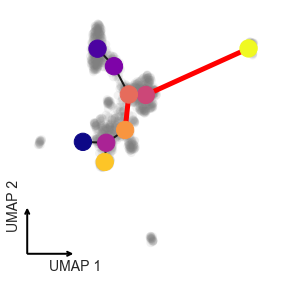

In [27]:
umap_set = set(retina.uns['X_umap_centroid_MST'].edges).difference(set(retina.uns['X_pca_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(umap_set)))

DR_plot(dim_name='UMAP', figsize=(4,4)).plot_centroids(adata=retina, obs_col='louvain', use_rep='X_umap', highlight_edges=umap_set)